# Gun Crime vs Population
Jake Perry

### Import dependencies
- from census import Census
- pandas as pd
- matplotlib.pyplot as plt
- from us import states
- os
- config file keys

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from census import Census
from us import states
from jmp_config import g_key
from jmp_config import census_key

### Import and clean CA crime data
- Get data from CSV file
- Clean up the county names
- Find only data for crimes with firearms
- Save a separate dataframe

In [2]:
#Set path for crime data from California
filepath = os.path.join('Data','Crimes_and_Clearances_with_Arson-1985-2019.csv')
df = pd.read_csv(filepath, low_memory=False)
#Remove 'county' from the County name field
df['County']=df['County'].str.replace(' County','')
#Remove unneeded fields.  
#'FROBact_sum' is total robberies with a firearm, actual offenses
#'FASSact_sum' is total assault with a firearm, actual offenses
df_clean=df[['Year','County','NCICCode','Violent_sum','FROBact_sum','FASSact_sum']]
#clean up column names
df_clean=df_clean.rename(columns={'FROBact_sum':'firearmRobberySum',
                                 'FASSact_sum':'firearmAssaultSum',
                                 'Violent_sum':'violentSum'})
df_clean['firearmTotal']=df_clean['firearmRobberySum']+df_clean['firearmAssaultSum']
df_clean.head()

,Year,County,NCICCode,violentSum,firearmRobberySum,firearmAssaultSum,firearmTotal
0,1985,Alameda,Alameda Co. Sheriff's Department,427,77,25,102
1,1985,Alameda,Alameda,405,56,16,72
2,1985,Alameda,Albany,101,23,3,26
3,1985,Alameda,Berkeley,1164,242,47,289
4,1985,Alameda,Emeryville,146,35,6,41


### Import and clean Census data
- Get data from census API (2009 through 2019 is what is available)
- Get population data for CA
- Bonus: get population data for each county (may not be available)
- Save data as a simple dataframe (year, population)
- Save a copy of data to share with project group

In [3]:
#Set up a dataframe with a call to the census API for 2009 county population data
year=2009
c=Census(census_key, year=year)
census_data = c.acs5.get(('NAME','B01003_001E'), geo={'for': 'county:*',
                       'in': 'state:{}'.format(states.CA.fips)})
# Save as dataframe
CAPop_df = pd.DataFrame(census_data)

# Rename columns
CAPop_df = CAPop_df.rename(columns={"B01003_001E": "Population",
                                    "county":'countyNo',
                                    "state":'stateNo'})
#Add a column that only has the county name
CAPop_df['County']=CAPop_df['NAME'].str.replace(' County, California','')

#Add a year column
CAPop_df['Year']= year



#Set up a loop to get the rest of the data for years 2010-2019
for year in range(2010,2020):
    
    c=Census(census_key, year=year)
    census_data = c.acs5.get(('NAME','B01003_001E'), geo={'for': 'county:*',
                       'in': 'state:{}'.format(states.CA.fips)})

    # Save as dataframe
    census_pd = pd.DataFrame(census_data)

    # Rename columns
    census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                    "county":'countyNo',
                                    "state":'stateNo'})
    #Add a column that only has the county name
    census_pd['County']=census_pd['NAME'].str.replace(' County, California','')
    
    #Add a year column
    census_pd['Year']=year
    
    # Append the existing CAPop_df dataframe with the results from the current iteration
    CAPop_df=CAPop_df.append(census_pd,ignore_index=True)

CAPop_df.head()
#Save a copy of CA county populations to share with project group
CAPop_df.to_csv('Data/CA_CountyPop_2009to2019.csv')

### Group crime data
- Group by year
- Get total gun crimes per year
- Get total gun crimes per 100,000 people
- Bonus: group by county (if county population data is available)
- Bonus: get gun crimes per county
- Bonus: get gun crimes per 100,000 people in a county

In [4]:
#Total gun crimes in CA by year
gunCrime = df_clean.loc[df_clean['Year']>=2009]
gunYears=gunCrime.groupby('Year')
gunCrimeByYear=gunYears['firearmTotal'].sum()

#CA population by year
CAyears=CAPop_df.groupby('Year')
CAPopByYear = CAyears['Population'].sum()
CAPopByYear

#Combine groupby series
CAGunsYears = pd.concat([gunCrimeByYear,CAPopByYear],axis=1).reset_index()
CAGunsYears = CAGunsYears.rename(columns={
    'firearmTotal':'TotalGunCrimes'
})

#Calculate the number of gun crimes per 100,000 people for each year
CAGunsYears['GunCrimesPer100k']=round((CAGunsYears['TotalGunCrimes']/CAGunsYears['Population'])*100000,2)

#Get max and min populations to show on slides
print(CAGunsYears['Population'].max())
print(CAGunsYears['Population'].min())

39283497.0
36308527.0


In [5]:
#Total gun crimes by county by year
gunYearsCounty = gunCrime.groupby(['Year','County'])
gunCrimeByCountyYear=gunYearsCounty['firearmTotal'].sum()
gunCrimeByCountyYear

#CA population by year
CAyearsCounty=CAPop_df.groupby(['Year','County'])
CAPopByYearCounty = CAyearsCounty['Population'].sum()
CAPopByYearCounty

#Combine groupby series
CAGunsYearsCounty = pd.concat([gunCrimeByCountyYear,CAPopByYearCounty],axis=1).reset_index()
CAGunsYearsCounty = CAGunsYearsCounty.rename(columns={
    'firearmTotal':'TotalGunCrimes'
})

#Calculate the number of gun crimes per 100,000 people for each year
CAGunsYearsCounty['GunCrimesPer100k']=round((CAGunsYearsCounty['TotalGunCrimes']/CAGunsYearsCounty['Population'])*100000,2)

LAGunsYears = CAGunsYearsCounty.loc[CAGunsYearsCounty['County']=='Los Angeles']
#Print min and max population for slides
print(LAGunsYears['Population'].min())
print(LAGunsYears['Population'].max())

9758256.0
10105722.0


### Plot gun crime data
- Bar chart of gun crimes per year in CA
- Bar chart of population per year in CA
- Bar chart of gun crimes per year per capita in CA
- Bar chart of gun crimes per year in LA County
- Bar chart of population per year in LA County
- Bar chart of gun crimes per year in LA County per capita
- Scatter plots with fit lines and R-squared values for total gun crimes and population in each county, for 2009-2019
- Save charts to files

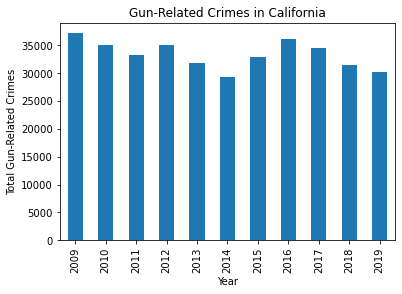

In [6]:
#Bar chart of CA gun grimes per year
gunCrimeByYear.plot(kind="bar")
plt.ylabel('Total Gun-Related Crimes')
plt.title('Gun-Related Crimes in California')
plt.savefig(os.path.join('JMP','JMP_GunRelatedCrimes_CA_09-19.png'),facecolor='white', transparent=False)
plt.show()

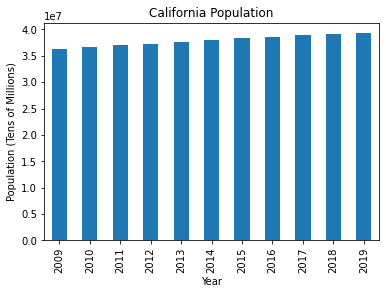

In [7]:
#Bar Chart of CA population per year
CAPopByYear.plot(kind="bar")
plt.ylabel("Population (Tens of Millions)")
plt.title("California Population")
plt.savefig(os.path.join('JMP','JMP_Population_CA_09-19.png'),facecolor='white', transparent=False)
plt.show()

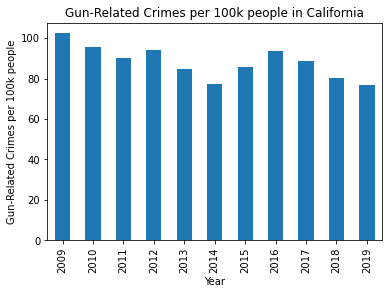

In [8]:
#Bar Chart of gun crimes per capita in CA
CAGunsPerCapita = CAGunsYears[['Year','GunCrimesPer100k']]
CAGunsPerCapita = CAGunsPerCapita.set_index('Year')
CAGunsPerCapita.plot(kind='bar', legend=False)
plt.ylabel('Gun-Related Crimes per 100k people')
plt.title('Gun-Related Crimes per 100k people in California')
plt.savefig(os.path.join('JMP','JMP_GunCrimesPerCapita_CA_09-19.png'),facecolor='white', transparent=False)
plt.show()

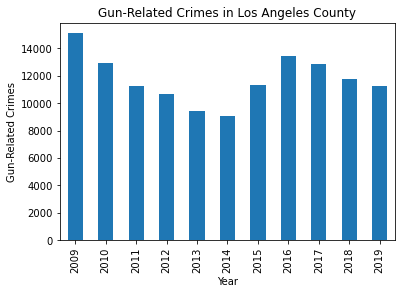

In [9]:
#Bar Chart of gun crimes per year in LA County
LAGunCrime = LAGunsYears[['Year','TotalGunCrimes']]
LAGunCrime = LAGunCrime.set_index('Year')
LAGunCrime.plot(kind='bar', legend=False)
plt.ylabel('Gun-Related Crimes')
plt.title('Gun-Related Crimes in Los Angeles County')
plt.savefig(os.path.join('JMP','JMP_GunRelatedCrimes_LA_09-19.png'),facecolor='white', transparent=False)
plt.show()

<ipython-input-10-d39a7122ffbc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LAPop['Population']=(LAPop['Population']/100000)


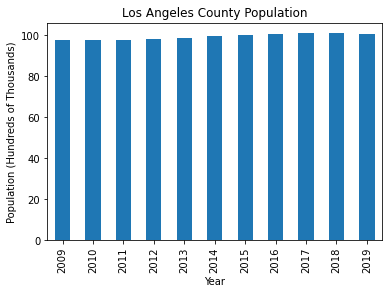

In [10]:
#Bar Chart of population in LA County
LAPop = LAGunsYears[['Year','Population']]
LAPop['Population']=(LAPop['Population']/100000)
LAPop = LAPop.set_index('Year')
LAPop.plot(kind='bar', legend=False)
plt.ylabel('Population (Hundreds of Thousands)')
plt.title('Los Angeles County Population')
plt.savefig(os.path.join('JMP','JMP_Population_LA_09-19.png'),facecolor='white', transparent=False)
plt.show()

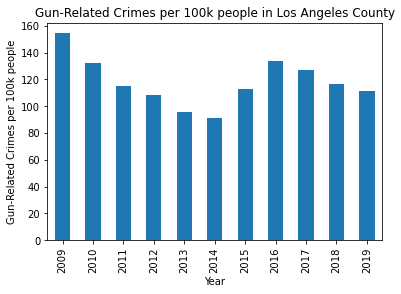

In [11]:
#Bar Chart of gun crimes per 100k people in LA County
LAGunCrimePC = LAGunsYears[['Year','GunCrimesPer100k']]
LAGunCrimePC = LAGunCrimePC.set_index('Year')
LAGunCrimePC.plot(kind='bar', legend=False)
plt.ylabel('Gun-Related Crimes per 100k people')
plt.title('Gun-Related Crimes per 100k people in Los Angeles County')
plt.savefig(os.path.join('JMP','JMP_GunCrimesPerCapita_LA_09-19.png'),facecolor='white', transparent=False)
plt.show()

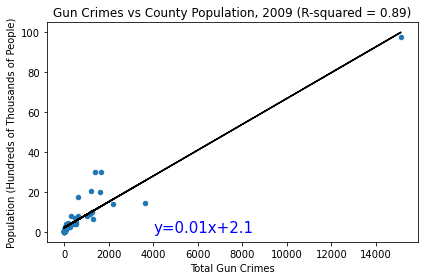

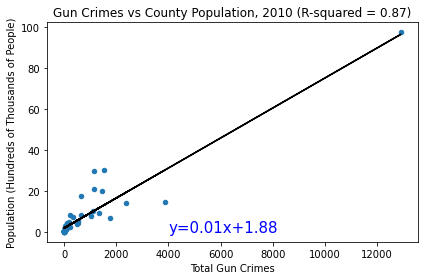

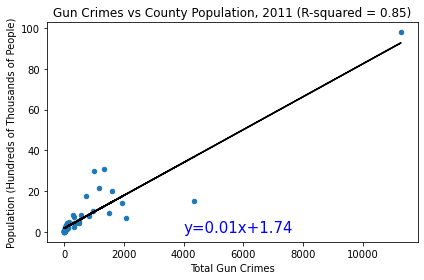

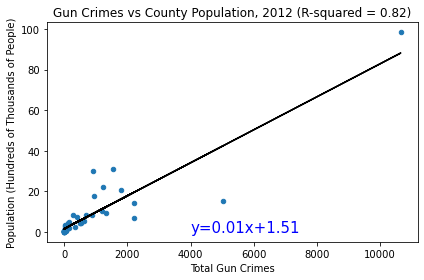

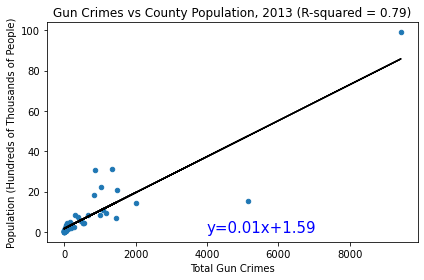

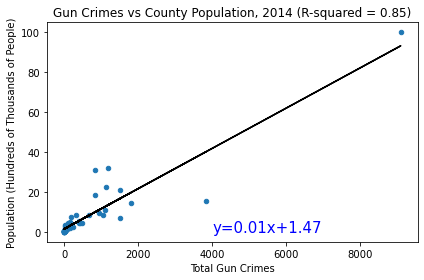

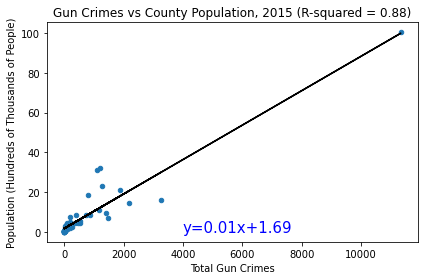

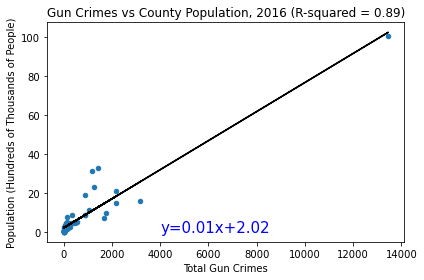

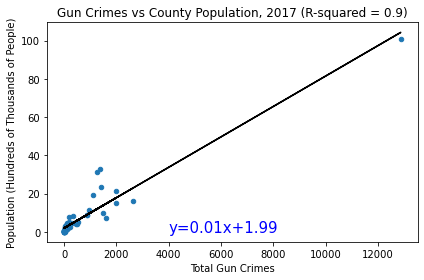

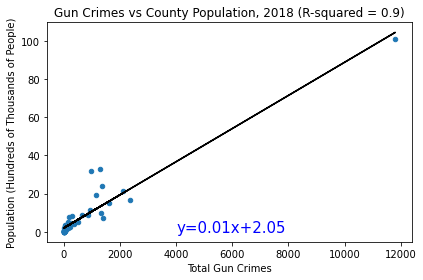

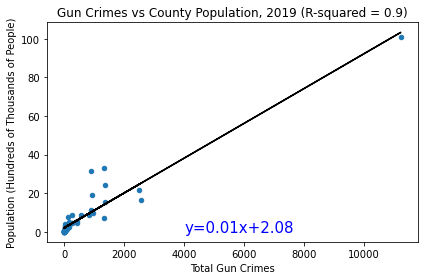

In [13]:
#Create a scatter plot of total gun crime and population for each county, for each year 2009-2019
#Presentation only includes odd-numbered years (2009,2011,2013,2015,2017,2019) to keep presentation concise
for year in range(2009,2020):
    CAGunsPop= CAGunsYearsCounty.loc[CAGunsYearsCounty['Year']==year]
    CAGunsPop = CAGunsPop[['TotalGunCrimes','Population']]
    CAGunsPop['Population']=(CAGunsPop['Population']/100000)
    CAGuns_slope, CAGuns_int, CAGuns_r, CAGuns_p, CAGuns_std_err = stats.linregress(CAGunsPop['TotalGunCrimes'], CAGunsPop['Population'])
    CAGuns_fit = CAGuns_slope * CAGunsPop['TotalGunCrimes'] + CAGuns_int
    CAGunsPop.plot(kind='scatter',x="TotalGunCrimes",y='Population')
    line_eq=f'y={round(CAGuns_slope,2)}x+{round(CAGuns_int,2)}'
    plt.annotate(line_eq,(6,10),fontsize=15,color="blue",xytext=(4000,0))
    plt.plot(CAGunsPop['TotalGunCrimes'],CAGuns_fit,"-",color='black')
    plt.ylabel('Population (Hundreds of Thousands of People)')
    plt.xlabel('Total Gun Crimes')
    plt.title(f'Gun Crimes vs County Population, {year} (R-squared = {round(CAGuns_r**2,2)})')
    plt.tight_layout()
    plt.savefig(os.path.join("JMP",f"JMP_CountyGunCrimesvPoplulation_{year}.png"),facecolor='white', transparent=False)
    plt.show()